In [1]:
# Imports
import math
import random
import statistics
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import optimize
import time
import seaborn as sns
sns.set_style("white")


# Define all functions used

In [2]:
def lossFunc(mu, sigma, t):
    # Random lognorm variate that starts at -1 standard dev
    
    # Calc 1 std. dev
    stdev_x = strikePrice * sigma * math.sqrt(t/365)
    
    # Draw from distribution 
    x = (-random.lognormvariate(mu, sigma) - stdev_x)/100 
    
    # Limit loss to 100%
    y = -1
    
    if x < -1:
        return y
    else:
        return x

def sellPutOption(cash, heldContracts, putContracts, strikePrice, profit_put, putITM):
    
    # Transaction cost
    cash -= transactionCost
    
    # Bookkeeping
    putContracts += 1
    
    # Case 1: Put Assigned -> You hold 100 shares 
    if random.random() < putITM: 
        heldContracts += 1
        cash -= strikePrice*100
        
    # Case 2: Put expires -> Profit
    else:
        pass
    
    cash += strikePrice * 100 * profit_put
    
    return cash, heldContracts, putContracts


def sellCallOption(cash, heldContracts, callContracts, strikePrice, periodsWithoutProfit, profit_hold, sellCall, mu, sigma, t):
    
    # Transaction cost
    cash -= transactionCost
    
    # Bookkeeping
    callContracts +=1
    
    # Get random call delta and call roc from distribution
    call_roc, call_delta = profitCall(strikePrice, t, sigma, r)
    profit_call = call_roc
    callITM = call_delta
    
    if heldContracts >= 1:
        # Case 1: Able to sell call on held shares
        if random.random() < sellCall:
            

            # Profit from recieved credit
            cash += strikePrice * 100 * profit_call


            # Subcase 1a: Shares called away, profit from call exercised
            if random.random() < callITM:
                cash += strikePrice * 100 
                heldContracts -= 1

             # Subcase 1b: Call expires
            else: 
                pass

        # Case 2: Unable to sell call, realizing a loss (drawn from lognormal dist)
        else:
            periodsWithoutProfit +=1
            cash +=  strikePrice * 100 * lossFunc(mu, sigma, t)
            pass
    
    else:
        #  No calls to sell shares on
        pass
    
    return cash, heldContracts, callContracts, periodsWithoutProfit, profit_call, callITM

def simulateOnePeriod(cash, period, heldContracts, strikePrice, periodsWithoutProfit, profit_put, profit_hold, putITM, sellCall, mu, sigma, t):
    
    # Initialize problem
    portfolioStart = cash + (heldContracts * strikePrice * 100)
    period += 1
    affordedContracts = math.floor(cash/(strikePrice*100))
    putsForSale = affordedContracts - heldContracts
    callsForSale = heldContracts
    
    putContracts = 0
    callContracts = 0 
    
     # Start selling put options
    while(putContracts <= putsForSale):
        cash, heldContracts, putContracts = sellPutOption(cash, heldContracts, putContracts, strikePrice, profit_put, putITM)

    # Start selling call options
    while(callContracts <= callsForSale):
        cash, heldContracts, callContracts, periodsWithoutProfit, profit_call, callITM = sellCallOption(cash, heldContracts, callContracts, strikePrice, periodsWithoutProfit,
                                                                             profit_hold, sellCall, mu, sigma, t)

    portfolioCurrent = cash + (heldContracts*strikePrice*100)
    returnPct = round((portfolioCurrent/portfolioStart)-1,3)
    
    return cash, portfolioCurrent, period, heldContracts, periodsWithoutProfit, profit_call, callITM


def runSimulations(profit_put, profit_hold, putITM, sellCall, mu, sigma, t, simulations = 10, periods=60, cashStart=10000,strikePrice=50,new_plot=False, figsize=(12, 6)):
    if new_plot:
        fig = plt.figure(figsize=figsize)
        ax = plt.axes()
        plt.grid(alpha = 0.2)
        plt.xlabel("Period $t$") #, size='14')
        plt.ylabel("Portfolio value $y_t$") #, size='14')
        ax.set_xlim(0,periods)
        #ax.set_title(f'put ITM: {putITM:.2f} | call ITM:{callITM:.2f} | sell call: {sellCall:.2f} | IV: {sigma:.2f}')
        ax.set_title(f' IV: {sigma:.2f} | sell call: {sellCall:.2f} | mean call ITM: 0.15 | put ITM: {putITM:.2f} ')

        
    # Initialize
    simulation = 0
    periodReturns = []
    totalReturnPCT = []
    totalReturn = []
    profitCalls = []
    callITMs = []

    while simulation < simulations:
        portfolioPreviousPeriod = cashStart
        period = 0
        portfolioCurrent = cashStart
        cash = cashStart
        heldContracts = 0
        periodsWithoutProfit = 0
        portfolioValue = []
        cashValue = []

        while period < periods:
            cash, portfolioCurrent, period, heldContracts, periodsWithoutProfit, profit_call, callITM = simulateOnePeriod(cash, period, heldContracts, strikePrice, periodsWithoutProfit,profit_put, profit_hold, putITM, sellCall, mu, sigma, t)
            portfolioValue.append(portfolioCurrent)
            cashValue.append(cash)
            periodReturns.append(portfolioCurrent/portfolioPreviousPeriod-1)
            portfolioPreviousPeriod = portfolioCurrent
            profitCalls.append(profit_call)
            callITMs.append(callITM)
            
            #Prints used for error checking
            #print(f' Sigma: {sigma_iv:.2f}, t: {t:.0f}, Put ITM:{putITM:.2f}, Call ITM: {callITM:.2f}, Profit put: {profit_put:.2f}, Profit call: {profit_call:.2f} sellCall: {sellCall:.2f}')#Return: {mean_annualized_ret:.2f}, Std dev: {mean_annualized_stdev:.2f}, Sharpe ratio: {mean_annualized_sharpe:.2f}, Cash util: {mean_cash_util:.2f}')
            #affordedContracts = math.floor(cash/(strikePrice*100))
            #print(f'period:{period},  heldcontracts: {heldContracts}, affordedContracts: {affordedContracts}, ')

        # Plots
        if new_plot:
            plt.plot(portfolioValue,linestyle="--",color="Grey")
            #plt.plot(cashValue,linestyle="-",color="green")
        
        # Bookkeeping
        simulation+=1
        
        # Collect return
        totalReturnPCT.append((portfolioCurrent/cashStart-1)*100)
        totalReturn.append(portfolioCurrent/cashStart)
        
        # Prints
        #print(f' for investor {simulation} the total return is {totalReturnPCT[simulation-1]:.0f}%, the annualized return is {((totalReturn[simulation-1]/100)**(1/(periods/12))-1)*100:.4f}%')

    return periodReturns, totalReturn, totalReturnPCT, portfolioValue, cashValue, profitCalls, callITMs


def runSimulation(profit_put, profit_hold, putITM, sellCall, mu, sigma, t, simulations = 10, periods=60, cashStart=100000,strikePrice=50,new_plot=False, figsize=(12, 6)):
    return runSimulations(profit_put, profit_hold, putITM, sellCall, mu, sigma, t, simulations = simulations, periods=periods, cashStart=cashStart,strikePrice=strikePrice,new_plot=new_plot, figsize=figsize)


# Black scholes implementation
def black_scholes(S0,X,t,sigma_iv, r,q=0.0,td=365):
    #https://unofficed.com/black-scholes-formula-in-python/
    
    S0,X,sigma_iv,r,q,t = float(S0),float(X),float(sigma_iv/100),float(r/100),float(q/100),float(t/td)
    d1 = (math.log(S0/X)+(r-q+0.5*sigma_iv**2)*t)/(sigma_iv*math.sqrt(t))
    Nd1 = (math.exp((-d1**2)/2))/math.sqrt(2*math.pi)
    d2 = d1-sigma_iv*math.sqrt(t)
    Nd2 = norm.cdf(d2)
    #call_theta =(-((S0*sigma_iv*math.exp(-q*t))/(2*math.sqrt(t))*(1/(math.sqrt(2*math.pi)))*math.exp(-(d1*d1)/2))-(r*X*math.exp(-r*t)*norm.cdf(d2))+(q*math.exp(-q*t)*S0*norm.cdf(d1)))/td
    #put_theta =(-((S0*sigma_iv*math.exp(-q*t))/(2*math.sqrt(t))*(1/(math.sqrt(2*math.pi)))*math.exp(-(d1*d1)/2))+(r*X*math.exp(-r*t)*norm.cdf(-d2))-(q*math.exp(-q*t)*S0*norm.cdf(-d1)))/td
    call_premium =math.exp(-q*t)*S0*norm.cdf(d1)-X*math.exp(-r*t)*norm.cdf(d1-sigma_iv*math.sqrt(t))
    put_premium =X*math.exp(-r*t)*norm.cdf(-d2)-math.exp(-q*t)*S0*norm.cdf(-d1)
    call_delta =math.exp(-q*t)*norm.cdf(d1)
    put_delta =math.exp(-q*t)*(norm.cdf(d1)-1)
    #gamma =(math.exp(-r*t)/(S0*sigma_iv*math.sqrt(t)))*(1/(math.sqrt(2*math.pi)))*math.exp(-(d1*d1)/2)
    #vega = ((1/100)*S0*math.exp(-r*t)*math.sqrt(t))*(1/(math.sqrt(2*math.pi))*math.exp(-(d1*d1)/2))
    #call_rho =(1/100)*X*t*math.exp(-r*t)*norm.cdf(d2)
    #put_rho =(-1/100)*X*t*math.exp(-r*t)*norm.cdf(-d2)
    
    call_roc = call_premium/X 
    put_roc = put_premium/X   

    return (call_premium, put_premium, call_delta, put_delta, call_roc, put_roc)
    
def findSpotPut(target_delta, spot, S0, X, t, sigma_iv, r, q=0.0, td=365, i=0, max_iter=500):
    
    target_delta = target_delta * -1
    
    # inner function
    def f(p):
        # Set spot
        S0 = p
        # Calculate the delta
        call_premium, put_premium, call_delta, put_delta, call_roc, put_roc = black_scholes(S0,X,t,sigma_iv,r,q=0.0,td=365)

        distance = put_delta-target_delta
        
        #print(f'Iteration {i}:, spot {spot:.2f}, put_delta {put_delta:.2f}, target_delta: {target_delta:.2f}, distance {round(put_delta-target_delta,3)} ')

        return distance
    
    # Find root
    result = optimize.root_scalar(f,bracket=[1,500],method='brentq', maxiter=max_iter)
    
    
    return(result.root)

def profitRangePut(delta_range, price, X, t, sigma_iv, r):
    spot_range = []
    for target_delta in delta_range:
        price = findSpotPut(target_delta, price, S0, X, t, sigma_iv=sigma_iv, r=r, q=0.0, td=365, i=0, max_iter=5000)
        spot_range.append(price)

    profit_range = [] # in %
    for price in spot_range:
        call_premium, put_premium, call_delta, put_delta, call_roc, put_roc = black_scholes(price,X,t,sigma_iv=sigma_iv,r=r,q=0.0,td=365)
        profit_range.append(put_roc)
        
    return profit_range



def profitCall(strikePrice, t, sigma, r):
    
    S0 = strikePrice
    X = strikePrice
    
    # Call delta is limited to:
    stdev_x = strikePrice * sigma * math.sqrt(t/365)
    x = -(-random.lognormvariate(mu, sigma) - stdev_x) 
    S1 = max(S0-x, 0.001) # avoid valueerror in blackscholes with sqrt(0)
    
    call_premium, put_premium_, call_delta, put_delta_, call_roc, put_roc_ = black_scholes(S1,X,t,sigma_iv,r,q=0.0,td=365)
    
    if call_delta < 0.05:
        call_delta == 0
        call_roc == 0
    
    return call_roc, call_delta


def runSimulationRanges(j, periods, delta_range, sigma_iv,  X, t, max_iter, i, price_p, price_c, S0, r, annualizefactor, new_plot=False):
    # Generate profit ranges
    profit_put = profitRangePut(delta_range, price_p, X, t, sigma_iv, r)

    # Set profit and delta pars
    putITM = delta_range[j]
    profit_put = profit_put[j]
    profit_hold = -0
    
    sigma = sigma_iv/100
    x_ = math.exp(mu)
    shape = sigma
    sellCall = lognorm.cdf(x_, shape, loc=0, scale=sigma)

    # Run sim
    periodReturns, totalReturn, totalReturnPCT, portfolioValue, cashValue, profitCalls, callITMs = runSimulation(profit_put, profit_hold, putITM, sellCall, mu, sigma, t, simulations = simulations,
                                            cashStart = cashStart, figsize = figsize, periods = periods, strikePrice = strikePrice, new_plot=new_plot)

    # Cash utilization
    cashUtil = np.array(cashValue) / np.array(portfolioValue)

    # Descriptive stats
    mean_callITM = statistics.mean(callITMs)
    mean_callroc = statistics.mean(profitCalls)
    mean_growth = statistics.mean(periodReturns)
    std_dev = statistics.stdev(periodReturns)
    mean_cash_util = statistics.mean(cashUtil)


    # Annualized measures
    mean_annualized_ret = ((1+mean_growth)**annualizefactor-1)
    mean_annualized_stdev = std_dev*math.sqrt(annualizefactor)
    mean_annualized_sharpe = mean_annualized_ret/mean_annualized_stdev
    
    # Prints
    print(f' Sigma: {sigma_iv:.2f}, t: {t:.0f}, Put ITM: {putITM:.2f}, Mean call ITM: {mean_callITM:.2f}, Profit put: {profit_put:.3f}, Mean profit call: {mean_callroc:.3f}, sellCall: {sellCall:.2f}, Return: {mean_annualized_ret:.2f}, Std dev: {mean_annualized_stdev:.2f}, Sharpe ratio: {mean_annualized_sharpe:.2f}, Cash util: {mean_cash_util:.2f}')
    return putITM, mean_callITM, profit_put, mean_callroc, sellCall, mean_annualized_ret, mean_annualized_stdev, mean_annualized_sharpe, mean_cash_util

# Risk - return profiles:


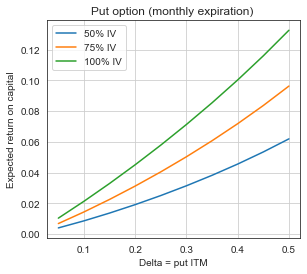

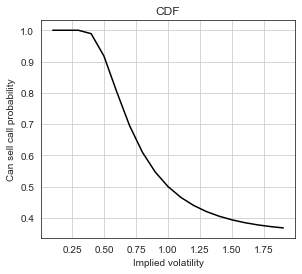

In [3]:
# Delta range
delta_range = np.arange(0.05, 0.55, 0.05)
sigma_iv = 100 #in %
max_iter = 500
i = 0
price = 100
price_p = 100
price_c = 100
S0 = price
X = 50
t = 365/12
r = (1+0.009)*12
profit_put_50iv = np.array(profitRangePut(delta_range, price, X, t, 50, r))
profit_put_75iv = np.array(profitRangePut(delta_range, price, X, t, 75, r))
profit_put_100iv = np.array(profitRangePut(delta_range, price, X, t, 100, r))


# Can sell call % vs Implied volatility
# Sigma range (IV)
sigma_range = np.arange(0.1, 2, 0.1)

# Sell call probability range, # Sellcall % = probability of less than 1 std. deviation move
mu = 0
sellCall_range =[]

for sigma in sigma_range:
    x = math.exp(mu)
    shape = sigma
    sc = lognorm.cdf(x, shape, loc=0, scale=sigma)
    sellCall_range.append(sc)

# Create the figure
fig = plt.figure(figsize=(10,4))# figsize is in inches...

#legend(loc="upper left")

# Left plot
ax_left = fig.add_subplot(1,2,1)
ax_left.plot(delta_range,profit_put_50iv)
ax_left.plot(delta_range,profit_put_75iv)
ax_left.plot(delta_range,profit_put_100iv)
plt.gca().legend(('50% IV','75% IV','100% IV'))

ax_left.set_title(f'Put option (monthly expiration) ')
ax_left.set_xlabel('Delta = put ITM')
ax_left.set_ylabel('Expected return on capital')
ax_left.grid(True)

plt.savefig('tradeoff2.png', bbox_inches='tight')

# Create the figure
fig = plt.figure(figsize=(10,4))# figsize is in inches...

ax_right = fig.add_subplot(1,2,2)
ax_right.plot(sigma_range,sellCall_range, color="black")
ax_right.set_title('CDF')
ax_right.set_xlabel('Implied volatility')
ax_right.set_ylabel('Can sell call probability')
ax_right.grid(True)
plt.savefig('sellcallprob.png', bbox_inches='tight')


# Simulations for each risk profile and time to EXP


## Important simulation settings

In [35]:
# The same for all sims
cashStart= 100000
strikePrice= 100
transactionCost = 25

figsize = (8,6)

## Baseline model, monthly expiration

The mean call delta sold is 0.15
The mean call profit is 0.0090
The mean annualized return is 0.0295
The mean annualized std dev 0.0369
The mean annualized sharpe ratio is 0.7997


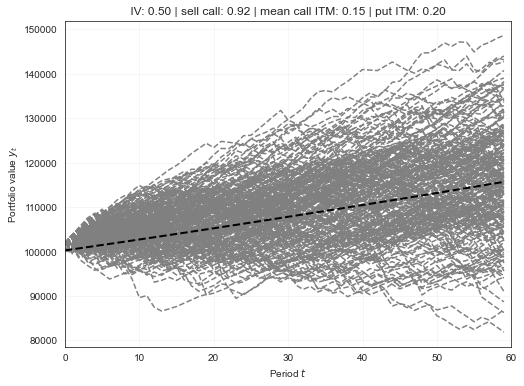

In [36]:
### Baseline model, monthly expiration
random.seed(1)
simulation = 0
simulations = 250

# Monthly sim
periods=60 # 5 years in months
annualizefactor=12 #used when annualizing return
t = (periods*(365/12))/periods # DTE in days converted from months

# Parameters
sigma_iv = 50
max_iter = 500
S0 = price
X = strikePrice
r = (1+0.009)*12



# Generate profit ranges
profit_put = np.array(profitRangePut(delta_range, price, X, t, sigma_iv, r))


# Set profit and delta pars
putITM = delta_range[3]
profit_put = profit_put[3]
profit_hold = -0

sigma = sigma_iv/100
x_ = math.exp(mu)
shape = sigma
sellCall = lognorm.cdf(x_, shape, loc=0, scale=sigma)

# Run sim
periodReturns, totalReturn, totalReturnPCT, portfolioValue, cashValue, profitCalls, callITMs = runSimulation(profit_put, profit_hold, putITM, sellCall, mu, sigma, t, simulations = simulations,
                                            cashStart = cashStart, figsize = figsize, periods = periods, strikePrice = strikePrice, new_plot=True)

# Cash utilization
cashUtil = np.array(cashValue) / np.array(portfolioValue)

# Descriptive stats
mean_callITM = statistics.mean(callITMs)
mean_callroc = statistics.mean(profitCalls)
mean_growth = statistics.mean(periodReturns)
std_dev = statistics.stdev(periodReturns)
mean_cash_util = statistics.mean(cashUtil)

# Mean growth line 
period = 0
mean_fit = []
start_value = cashStart
last_value = cashStart
while period < periods:
    this_value = last_value *(1+mean_growth)
    mean_fit.append(this_value)
    period += 1
    last_value = this_value
    
plt.plot(mean_fit,linestyle="--",color="black",linewidth=2)

mean_annualized_ret = ((1+mean_growth)**annualizefactor-1)
mean_annualized_stdev = std_dev*math.sqrt(annualizefactor)
mean_annualized_sharpe = mean_annualized_ret/mean_annualized_stdev
print(f'The mean call delta sold is {mean_callITM:.2f}')
print(f'The mean call profit is {mean_callroc:.4f}')
print(f'The mean annualized return is {mean_annualized_ret:.4f}')
print(f'The mean annualized std dev {mean_annualized_stdev:.4f}')
print(f'The mean annualized sharpe ratio is {mean_annualized_sharpe:.4f}')
#print(f' Sigma: {sigma_iv:.2f}, t: {t:.0f}, Put ITM:{putITM:.2f}, Call ITM: {callITM:.2f}, Profit put: {profit_put:.2f}, Profit call: {profit_call:.2f} sellCall: {sellCall:.2f}, Return: {mean_annualized_ret:.2f}, Std dev: {mean_annualized_stdev:.2f}, Sharpe ratio: {mean_annualized_sharpe:.2f}, Cash util: {mean_cash_util:.2f}')
    

# Save figure

plt.savefig('baselinemodelv2.png', bbox_inches='tight')

#totalReturns = pd.DataFrame(totalReturn)
#totalReturns.describe(totalReturns)


## All parameter combinations

In [37]:
#### Dont run sims each time
break
####
#last run - 21 min
# --- 1144.8027293682098  seconds --- 
###

# Setting the number of simulations higher drastically increases runtime
simulation = 0
simulations = 25

start_time = time.time()

# The same for all sims
random.seed(1)
simulation = 0
simulations = 25
figsize = (8,6)

max_iter = 500
i = 0
S0 = 1
X = strikePrice
r = (1+0.009)*12

delta_range = np.arange(0.05, 0.55, 0.05)
par_range = np.arange(0, len(delta_range), 1)
sigma_iv_range = (50, 60, 70, 80, 90, 100, 110, 120) #np.arange(50, 125, 50) # 

# Weekly sim
periods=60*52/12 # 5 years in weeks
t = (periods*(365/52))/periods # DTE in days converted from weeks
annualizefactor = 52

data_weekly = []
for sigma_iv in sigma_iv_range:
    for j in par_range:
        putITM, callITM, profit_put, profit_call, sellCall, mean_annualized_ret, mean_annualized_stdev, mean_annualized_sharpe, mean_cash_util = runSimulationRanges(j, periods, delta_range, sigma_iv,  X, t, max_iter, i, price_p, price_c, S0, r, annualizefactor, new_plot=False)
        data_weekly.append([t, sigma_iv , putITM, callITM, profit_put, profit_call, sellCall, mean_annualized_ret, mean_annualized_stdev, mean_annualized_sharpe, mean_cash_util])
        #print(f' Sigma: {sigma_iv}, j: {j}, Put ITM:{putITM}, Call ITM: {callITM}, sellCall: {sellCall}, Return: {mean_annualized_ret:.2f}, Std dev: {mean_annualized_stdev:.2f}, Sharpe ratio: {mean_annualized_sharpe:.2f}')
            
sim_results_weekly = pd.DataFrame(data_weekly, columns=['t', 'ImpliedVolatility', 'putITM', 'callITM', 'profit_put', 'profit_call', 'sellCall', 'mean_annualized_ret', 'mean_annualized_stdev', 'mean_annualized_sharpe', 'mean_cash_util'])


# Monthly sim
periods=60 # 5 years in months
annualizefactor=12 #used when annualizing return
t = (periods*(365/12))/periods # DTE in days converted from months

data_monthly = []
for sigma_iv in sigma_iv_range:
    for j in par_range:
        putITM, callITM, profit_put, profit_call, sellCall, mean_annualized_ret, mean_annualized_stdev, mean_annualized_sharpe, mean_cash_util = runSimulationRanges(j, periods, delta_range, sigma_iv,  X, t, max_iter, i, price_p, price_c, S0, r, annualizefactor, new_plot=False)
        data_monthly.append([t, sigma_iv , putITM, callITM, profit_put, profit_call, sellCall, mean_annualized_ret, mean_annualized_stdev, mean_annualized_sharpe, mean_cash_util])
        #print(f' Sigma: {sigma_iv}, j: {j}, Put ITM:{putITM}, Call ITM: {callITM}, sellCall: {sellCall}, Return: {mean_annualized_ret:.2f}, Std dev: {mean_annualized_stdev:.2f}, Sharpe ratio: {mean_annualized_sharpe:.2f}')
            
sim_results_monthly = pd.DataFrame(data_monthly, columns=['t', 'ImpliedVolatility', 'putITM', 'callITM', 'profit_put', 'profit_call', 'sellCall', 'mean_annualized_ret', 'mean_annualized_stdev', 'mean_annualized_sharpe', 'mean_cash_util'])
        
    
# Yearly sim
periods=10 # 10 years in years
t = (periods*365)/periods # DTE in days converted from years
annualizefactor = 1

data_yearly = []
for sigma_iv in sigma_iv_range:
    for j in par_range:
        putITM, callITM, profit_put, profit_call, sellCall, mean_annualized_ret, mean_annualized_stdev, mean_annualized_sharpe, mean_cash_util = runSimulationRanges(j, periods, delta_range, sigma_iv,  X, t, max_iter, i, price_p, price_c, S0, r, annualizefactor, new_plot=False)
        data_yearly.append([t, sigma_iv , putITM, callITM, profit_put, profit_call, sellCall, mean_annualized_ret, mean_annualized_stdev, mean_annualized_sharpe, mean_cash_util])
        #print(f' Sigma: {sigma_iv}, j: {j}, Put ITM:{putITM}, Call ITM: {callITM}, sellCall: {sellCall}, Return: {mean_annualized_ret:.2f}, Std dev: {mean_annualized_stdev:.2f}, Sharpe ratio: {mean_annualized_sharpe:.2f}')
             
sim_results_yearly = pd.DataFrame(data_yearly, columns=['t', 'ImpliedVolatility', 'putITM', 'callITM', 'profit_put', 'profit_call', 'sellCall', 'mean_annualized_ret', 'mean_annualized_stdev', 'mean_annualized_sharpe', 'mean_cash_util'])
###
print("--- %s seconds ---" % (time.time() - start_time))


SyntaxError: 'break' outside loop (<ipython-input-37-afb98160cd7b>, line 2)

In [ ]:
# Collect simulation results
all_sim_results = pd.concat([sim_results_weekly, sim_results_monthly, sim_results_yearly], ignore_index=True)

# Export to excel
#all_sim_results.to_excel("output2_tc.xlsx")  
#all_sim_results.to_excel("output2_no_tc.xlsx")  

In [11]:
# Import from excel
#all_sim_results = pd.read_excel(r'C:\Users\Carla\Dropbox\Uni\9. Semester\Seminar\output2_tc.xlsx')
#all_sim_results = pd.read_excel(r'C:\Users\Carla\Dropbox\Uni\9. Semester\Seminar\output2_no_tc.xlsx')

In [12]:
### Filter outliers
sim_results_copy = all_sim_results.copy()

# For sharpe ratio, remove values that are > 500
I = sim_results_copy['mean_annualized_sharpe'] > 100 #filter expression
sim_results_copy.drop(sim_results_copy[I].index, inplace=True)

# For return , remove values that are > 500
I = sim_results_copy['mean_annualized_ret'] > 100 #filter expression
sim_results_copy.drop(sim_results_copy[I].index, inplace=True)

# For std dev , remove values that are > 500
I = sim_results_copy['mean_annualized_stdev'] > 100 #filter expression
sim_results_copy.drop(sim_results_copy[I].index, inplace=True)

# Format days as integers
sim_results_copy['t'] = sim_results_copy['t'].astype('int64')

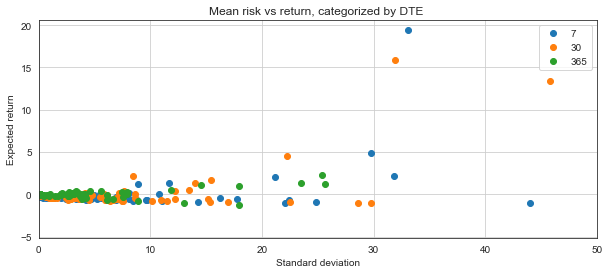

In [13]:
fig = plt.figure(figsize=(10,4))# figsize is in inches...
groups = sim_results_copy.groupby("t")
for name, group in groups:
    plt.plot(group["mean_annualized_stdev"], group["mean_annualized_ret"], marker="o", linestyle="", label=name)
plt.legend()
plt.grid(True)
plt.xlabel(f'Standard deviation')
plt.ylabel(f'Expected return')
plt.title(f'Mean risk vs return, categorized by DTE ')
plt.xlim(0, 50)
#plt.ylim(0, 10)

# Save figure
plt.savefig('simresults1.png', bbox_inches='tight')


In [15]:
### Sorting best results
best_results = sim_results_copy.copy()
best_results = best_results.sort_values(by=['mean_annualized_sharpe'], ascending=False)

best_results_7 = best_results.copy() 
best_results_7 = best_results_7[best_results.t == 7] 

best_results_30 = best_results.copy() 
best_results_30 = best_results_30[best_results.t == 30] 

best_results_365 = best_results.copy() 
best_results_365 = best_results_365[best_results.t == 365] 

# For presentation
all_br = pd.concat([best_results_7[:5], best_results_30[:5], best_results_365[:5]], ignore_index=True)

# Drop unnessecary cols
all_br.drop(['Unnamed: 0', 'mean_cash_util'],axis=1,inplace=True)
#all_br.drop(['mean_cash_util'],axis=1,inplace=True)

# Rename cols
all_br.columns=['DTE', 'IV', 'putITM', 'callITM', 'putROC', 'callROC', 'canSellCall', 'Expected return', 'Std dev', 'Sharpe ratio']

all_br.head()

# To latex
print(all_br.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrrrrrrrr}
\toprule
 DTE &   IV &  putITM &  callITM &  putROC &  callROC &  canSellCall &  Expected return &  Std dev &  Sharpe ratio \\
\midrule
   7 &  100 &   0.350 &    0.133 &   0.037 &    0.007 &        0.500 &           19.396 &   33.047 &         0.587 \\
   7 &   50 &   0.500 &    0.127 &   0.029 &    0.004 &        0.917 &            0.024 &    0.053 &         0.459 \\
   7 &   50 &   0.450 &    0.127 &   0.025 &    0.004 &        0.917 &            0.022 &    0.049 &         0.440 \\
   7 &  120 &   0.100 &    0.131 &   0.010 &    0.008 &        0.440 &            4.897 &   29.747 &         0.165 \\
   7 &   90 &   0.200 &    0.133 &   0.016 &    0.007 &        0.547 &            1.257 &    8.926 &         0.141 \\
  30 &   50 &   0.400 &    0.152 &   0.046 &    0.009 &        0.917 &            0.068 &    0.046 &         1.480 \\
  30 &   50 &   0.500 &    0.151 &   0.062 &    0.009 &        0.917 &            0.080 &    0.055 &         1.460 \\
  30 &   5